**CHAPTER 4 Data Pipeline Orchestration**

**4.1. Importing Modules**

In [ ]:
from airflow.models import DAG
from airflow.decorators import dag, task
from airflow.operators.python import PythonOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

MYSQL_CONNECTION = "mysql_default"   # Name of the connection in Airflow
CONVERSION_RATE_URL = "https://r2de3-currency-api-vmftiryt6q-as.a.run.app/gbp_thb"

# Output file path variables
mysql_output_path = "/home/airflow/gcs/data/transaction_data_merged.parquet"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.parquet"
final_output_path = "/home/airflow/gcs/data/workshop4_output.parquet"

**4.2 Default Arguments**

In [ ]:
default_args = {
    'owner': 'datath',
}

**4.3 Instantiate a Dag**

In [ ]:
@dag(default_args=default_args, schedule_interval="@once", start_date=days_ago(1), tags=["workshop"])
def workshop4_pipeline():

**4.4 Tasks**

In [ ]:
@task()
    def get_data_from_mysql(output_path):
        # Receives output_path from the calling task
        # Use MySqlHook to connect to MySQL using the Airflow connection
        mysqlserver = MySqlHook(MYSQL_CONNECTION)
        # Query data from database using the hook and return pandas DataFrames
        product = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.product")
        customer = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.customer")
        transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.transaction")

        # Merge data from 3 DataFrames as in Workshop1
        merged_transaction = transaction.merge(product, how="left", left_on="ProductNo", right_on="ProductNo").merge(customer, how="left", left_on="CustomerNo", right_on="CustomerNo")
        # Save as parquet file to output_path
        # It will be automatically uploaded to GCS
        merged_transaction.to_parquet(output_path, index=False)
        print(f"Output to {output_path}")

    @task()
    def get_conversion_rate(output_path):
        # Send a GET request to the conversion rate API
        r = requests.get(CONVERSION_RATE_URL)
        result_conversion_rate = r.json()
        df = pd.DataFrame(result_conversion_rate)
        df = df.drop(columns=['id'])
        # Convert column to datetime and save to parquet
        df['date'] = pd.to_datetime(df['date'])
        df.to_parquet(output_path, index=False)
        print(f"Output to {output_path}")

    @task()
    def merge_data(transaction_path, conversion_rate_path, output_path):
        # Read from files using the provided paths
        transaction = pd.read_parquet(transaction_path)
        conversion_rate = pd.read_parquet(conversion_rate_path)
        # Merge both DataFrames
        final_df = transaction.merge(conversion_rate, how="left", left_on="Date", right_on="date")
        # Calculate total_amount and thb_amount
        final_df["total_amount"] = final_df["Price"] * final_df["Quantity"]
        final_df["thb_amount"] = final_df["total_amount"] * final_df["gbp_thb"]
        # Drop unused columns and rename others
        final_df = final_df.drop(["date", "gbp_thb"], axis=1)
        final_df.columns = ['transaction_id', 'date', 'product_id', 'price', 'quantity', 'customer_id',
            'product_name', 'customer_country', 'customer_name', 'total_amount','thb_amount']

        # Save as parquet file
        final_df.to_parquet(output_path, index=False)
        print(f"Output to {output_path}")
        print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")

    t1 = get_data_from_mysql(output_path=mysql_output_path)
    t2 = get_conversion_rate(output_path=conversion_rate_output_path)
    t3 = merge_data(
            transaction_path=mysql_output_path,
            conversion_rate_path=conversion_rate_output_path,
            output_path=final_output_path
        )

**4.5 Setting up Dependencies**

In [ ]:
 [t1, t2] >> t3

workshop4_pipeline()

**Apendix**

A. Create Composer

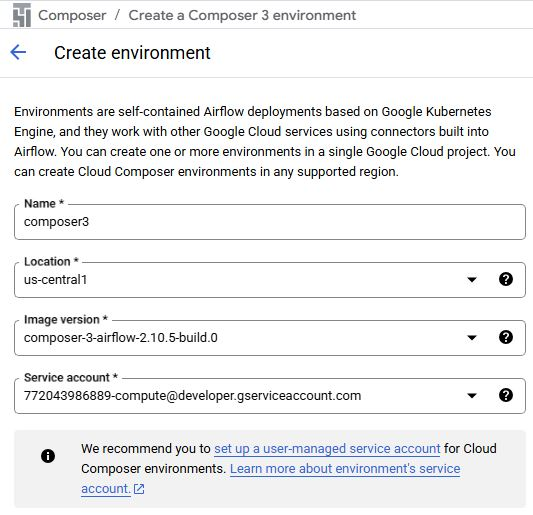

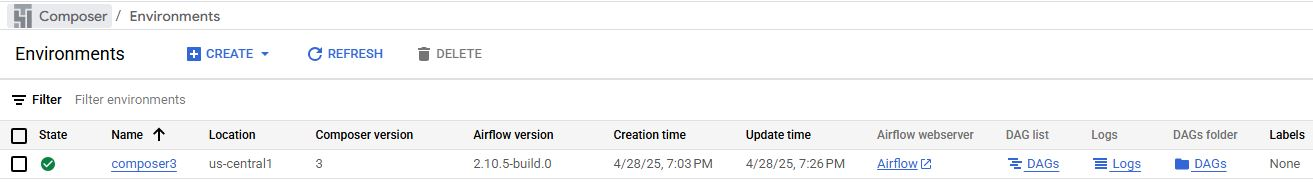

B. Copy pipeline to dags

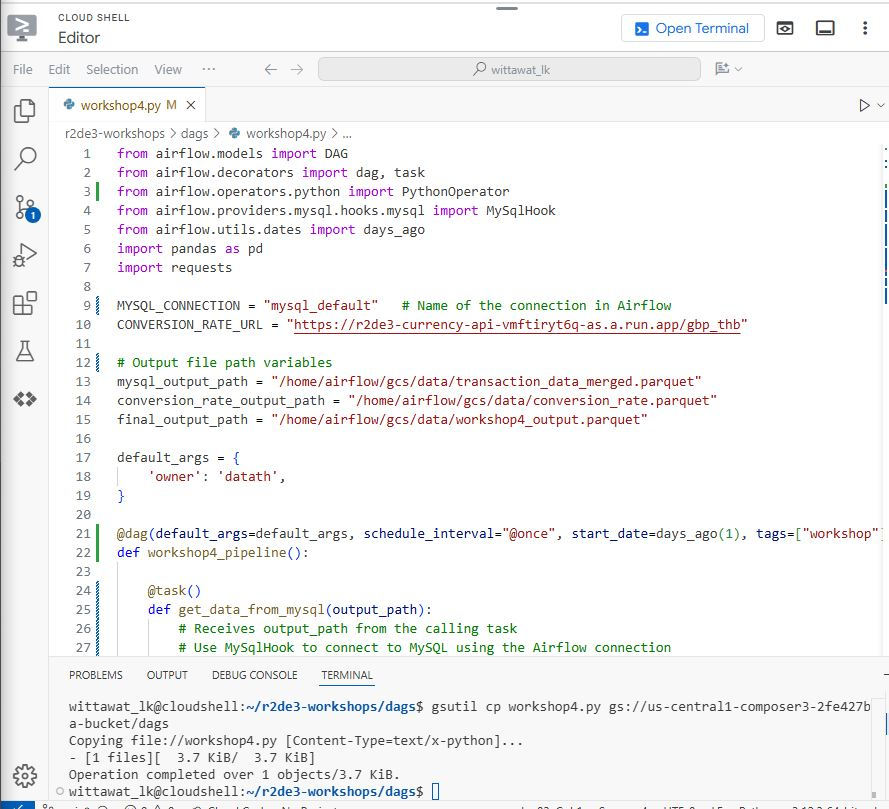

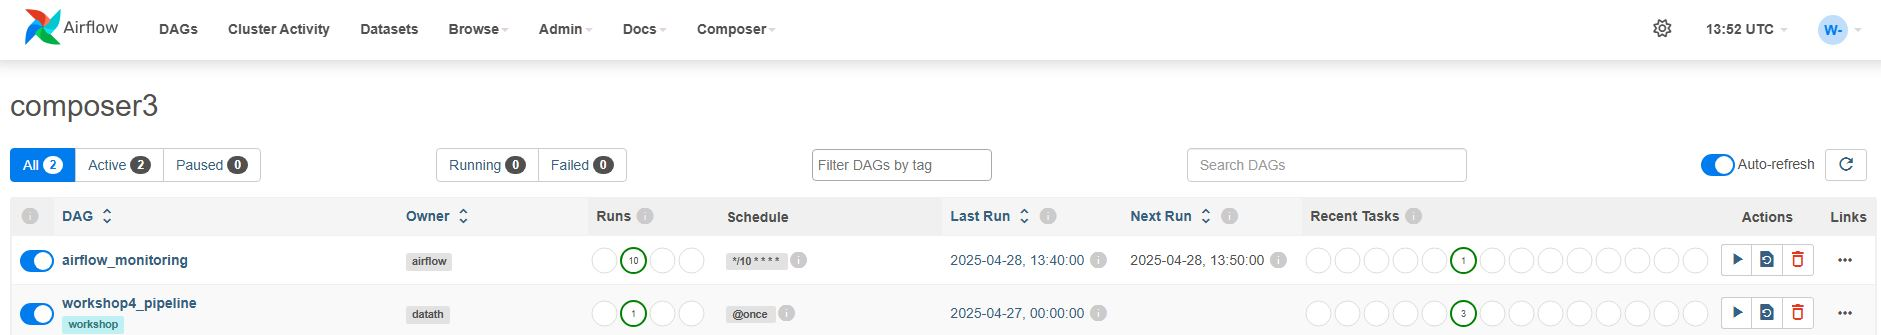

C. Pipeline output

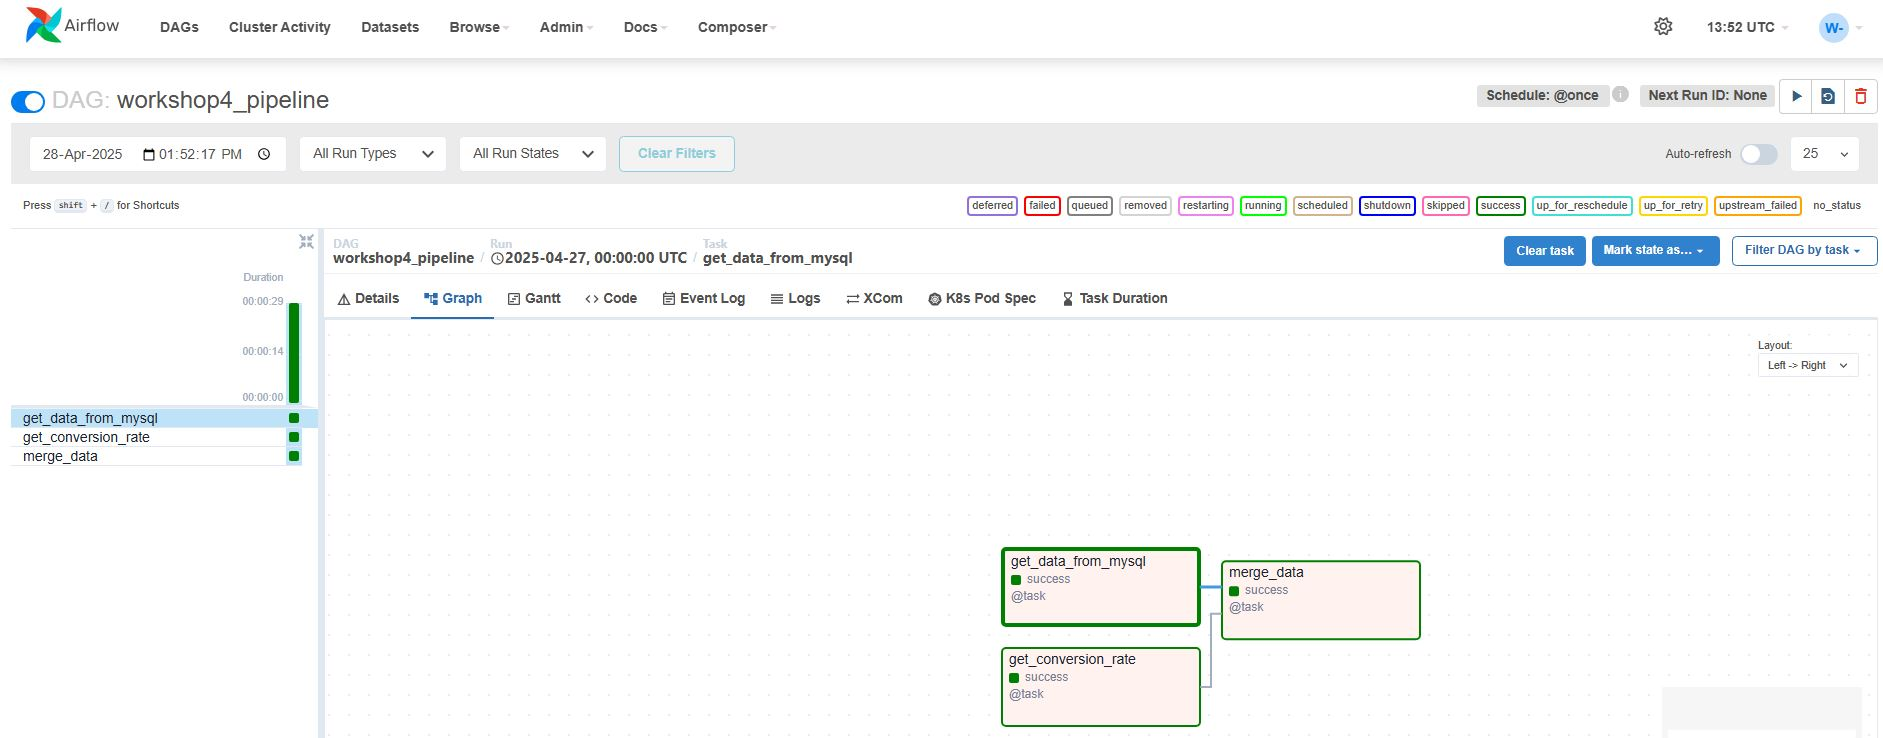

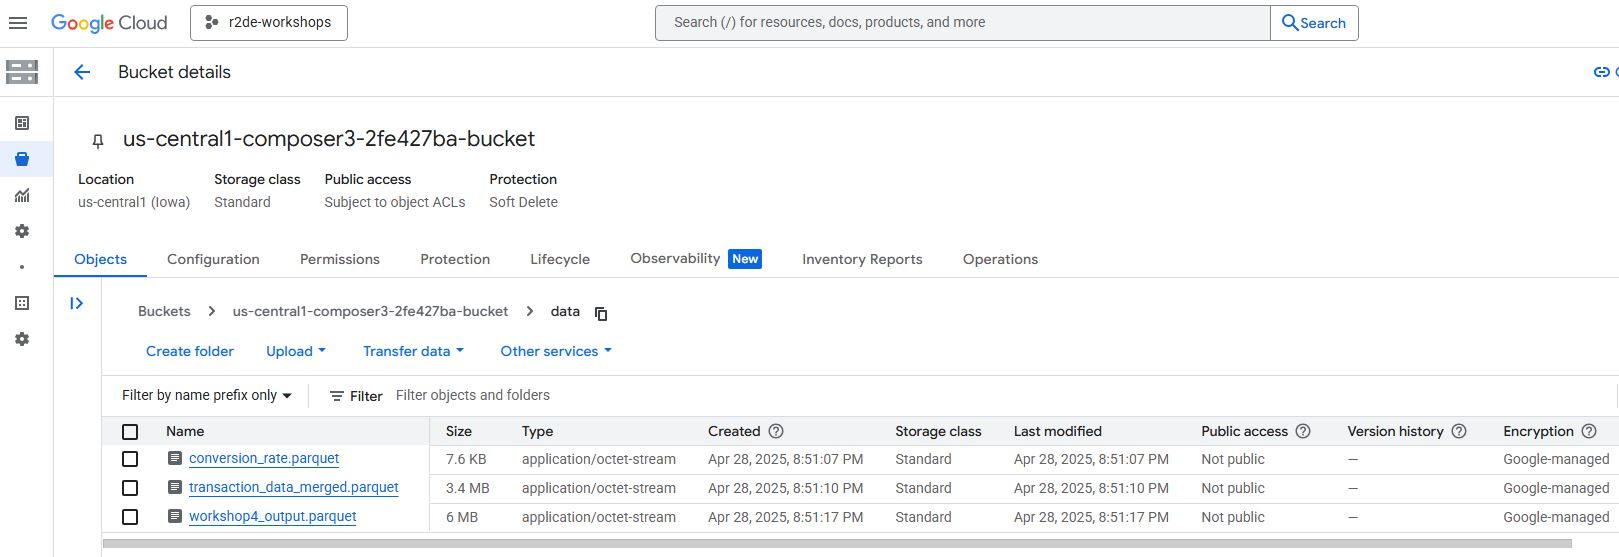